In [1136]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [1142]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "int/float powers only"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad = other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):  # other * self
        return self * other
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):  # other - self
        return -self + other
    
    def __radd__(self, other):
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1.0 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child) 
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            

In [1145]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        if n._op:        
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


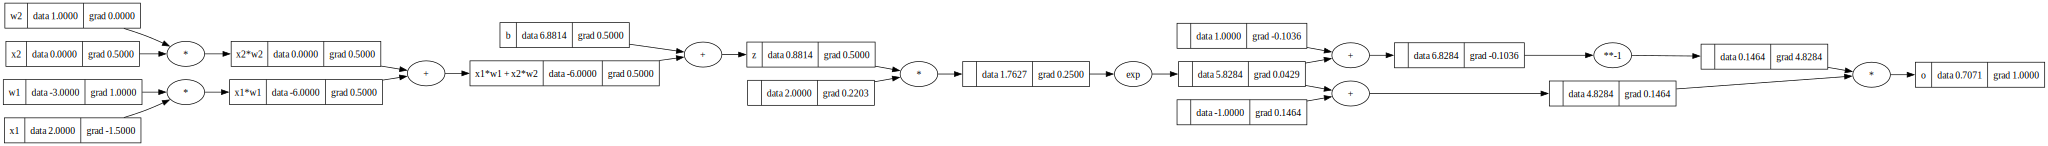

In [1148]:
x1 = Value(2., label='x1')
x2 = Value(0., label='x2')

w1 = Value(-3., label='w1')
w2 = Value(1., label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
z = x1w1x2w2 + b; z.label = 'z'

e = (2*z).exp()
o = (e-1)/(e+1)

o.label = 'o'
o.backward()
draw_dot(o)

In [1149]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # 
        # return params

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [1217]:
x = [2., 3., -1.]
n = MLP(3, [4, 4, 1])
# n(x)

In [1218]:
xs = [
    [2., 3., -1.],
    [3., -1., 0.5],
    [0.5, 1., 1.],
    [1., 1., -1.]
]
ys = [1., -1., -1., 1.]


In [1229]:
for k in range(20):
    # fwd pass
    ypred = [n(x) for x in xs]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))

    # resetting grad
    for p in n.parameters():
        p.grad = 0.0
        
    # back pass
    loss.backward()

    # grad des
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.008310286942183527
1 0.00821812179474565
2 0.00812790739857567
3 0.008039583338278809
4 0.007953091648406102
5 0.00786837669113008
6 0.007785385041151756
7 0.007704065377346069
8 0.007624368380691563
9 0.007546246638063774
10 0.007469654551504404
11 0.007394548252606912
12 0.007320885521685808
13 0.007248625711421779
14 0.007177729674696332
15 0.007108159696351547
16 0.0070398794286283106
17 0.006972853830054338
18 0.006907049107569577
19 0.006842432661691121


In [1230]:
ypred

[Value(data=0.9686492656064255),
 Value(data=-0.9743192541453959),
 Value(data=-0.9474608788681768),
 Value(data=0.9506066385257947)]

In [ ]:
draw_dot(n(xs[0]))